# 📜Summary
**Introduction:** The client is a large grocery store in Ecuador that wants to be more efficient in stocking inventory.

**Problem:** If inventory is oversupplied, unsold items will go to waste and are cost to the grocery. If inventory is undersupplied, there wouldn't be enough items to sell that meets demand and they would miss the opportunity to earn more money.

**Hypothesis:** If we are able to know how much inventory to supply in a given day, then we would minimize the cost of oversupplying items that does not sell and goes to waste. And maximizing revenue by having enough supply of items that we know will be in demand.

**Goal:** To predict and forecast the inventory needed to meet the demand of market.

-----
[Kaggle](https://www.kaggle.com/code/fiftythirtyfour/store-sales/)

# >🪴Selfnotes
## 🌿Focus on Training Data first
I learned that you need to focus first on making great predictions on training data before doing any validation. If your model sucks at Training data, then it will not be any better at your test data.

## 🌿Separate models for Linear Regression
If you do Linear regression on features that are unrelated with each other, you get weird stuff. The reason is Linear Regression assumes that a feature relates with another. Grocery items does not relate with Lipstick. So there should be no reason why we should use 1 to predict the other. This is why we create models separately. You can still do the pipeline prep on all of them but the models must be trained and predicted separately.

## 🌿Be better than the Average
Always starting by visualizing the target data with the average line. This is what you need to beat. From a straight line average to a wiggly line model predictions that is closely hug the target values.

## 🌿Fast Iteration
Let your mind go fast. Remove all friction and self-doubt. Just code and explore. Allow yourself to see your code as tools for discovery and experimentation, not a rigid framework.

## 🌿Store 52
There is a new store that will not have sales by August of 2017. So, don't train model by store_nbr.

In [1]:
from IPython.display import HTML

iframe_code = """
<iframe 
    width="1000" height="1500" 
    src="https://lookerstudio.google.com/embed/reporting/11c536c1-3cdd-4efd-b071-53ddf8b8edb4/page/8tZ1D" 
    frameborder="0" style="border:0" allowfullscreen 
    sandbox="
        allow-storage-access-by-user-activation 
        allow-scripts 
        allow-same-origin 
        allow-popups 
        allow-popups-to-escape-sandbox">
</iframe>
"""

display(HTML(iframe_code))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
import warnings
warnings.filterwarnings('ignore')

## Load
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')

## Clean

def getSalesBand(d):
    k = pd.cut(d.groupby('store_nbr')['sales'].mean()
           , bins=[0, 200, 500, 800, 1000, float('inf')]
           , labels=[1,2,3,4,5]
           , right=False
          )
    return k.to_dict()

def cleanData(a, st, oi, ho, ea, sb):
    a['date'] = pd.to_datetime(a['date'])
    a['year'] = a['date'].dt.year
    a['weekname'] = a.date.dt.day_name()
    a['month'] = a.date.dt.month
    a['weeknum'] = a['date'].dt.isocalendar().week
    a['dayofyear'] = a['date'].dt.strftime('%j').astype(int)
    a['store_nbr'] = a['store_nbr']
    a['store_type'] = a['store_nbr'].map(st)
    a['oil_price'] = a['date'].map(oi)
    a['holidays'] = a['date'].map(ho)
    a['earthquake'] = a['date'].map(ea)
    a['sales_band'] = a['store_nbr'].map(sb)
    return a

transactions['date'] = pd.to_datetime(transactions['date'])
stores['cluster'] = stores['cluster'].astype(str)
store_type = dict(zip(stores['store_nbr'], stores['type']))

oil['date'] = pd.to_datetime(oil['date'])
oil['inv_oil'] = 1/oil['dcoilwtico']
oil_price = dict(zip(oil['date'], oil['inv_oil']))

holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
holidays['date'] = pd.to_datetime(holidays['date'])
holidays = holidays.loc[~holidays['description'].str.startswith('Terremoto')]
holidays = holidays.query('transferred == False')
holidays['count'] = 1
holidays = holidays.groupby('date')['count'].max()
holidays = holidays.asfreq('D').fillna(0)
holidays.loc[(holidays.index.day == 1) | (holidays.index.day == 15)] = 1
holidays.loc[(holidays.index.weekday == 5) | (holidays.index.weekday == 6)] = 1
holidays = holidays.groupby((holidays.diff().fillna(0) != 0).cumsum()).cumsum()
holidays = dict(zip(holidays.index, holidays.values))

earthquake = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
earthquake['date'] = pd.to_datetime(earthquake['date'])
earthquake = earthquake.loc[earthquake['date'].dt.year == 2016]
earthquake = earthquake.loc[earthquake['description'].str.startswith('Terremoto')]
earthquake = earthquake.query('transferred == False')
earthquake['count'] = 1
earthquake = earthquake.groupby('date')['count'].max()

sales_band = getSalesBand(df)

df = cleanData(df, store_type, oil_price, holidays, earthquake, sales_band)

## Organize
target = 'sales'
cat = [x for x in df.columns if df.dtypes[x] == 'object']
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float64')]
num.remove('id')
num.remove('sales')

## train test split
train = df.loc[df['date'].dt.year == 2016]
test = df.loc[df['date'].dt.year == 2017]

# 🤓Data

# > Store Bands
I need to find a better way to group stores based on their volume.

In [3]:
g = train
g.groupby(['sales_band', 'store_nbr'])[target].mean().dropna()

sales_band  store_nbr
1           10            190.219232
            12            230.642259
            13            209.234615
            16            196.016421
            21            342.607443
            22            171.057053
            26            145.855892
            29            347.325573
            30            161.489060
            32            122.927157
            35            166.611850
            42            358.345114
            52              0.000000
            54            244.444975
2           1             314.943356
            2             488.668592
            4             414.476104
            5             298.735491
            6             550.879999
            7             624.284829
            9             564.072826
            14            235.917362
            15            241.324803
            17            431.826706
            18            223.387027
            19            277.618651
            20  

# > Understanding the Holidays
Ignore the transferred holidays because they were not celebrated on that day.

In [4]:
# holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
# holidays['date'] = pd.to_datetime(holidays['date'])
# holidays = holidays.loc[holidays['date'].dt.year == 2016]
# holidays = holidays.loc[~holidays['description'].str.startswith('Terremoto')]
# holidays = holidays.query('transferred == False')
# holidays['count'] = 1
# holidays = holidays.groupby('date')['count'].max()
# holidays = holidays.asfreq('D').fillna(0)
# holidays.loc[(holidays.index.day == 1) | (holidays.index.day == 15)] = 1
# holidays.loc[(holidays.index.weekday == 5) | (holidays.index.weekday == 6)] = 1
# holidays = holidays.groupby((holidays.diff().fillna(0) != 0).cumsum()).cumsum()
# # holidays = dict(zip(holidays.index, holidays.values))
# holidays

In [5]:
# earthquake = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
# earthquake['date'] = pd.to_datetime(earthquake['date'])
# earthquake = earthquake.loc[earthquake['date'].dt.year == 2016]
# earthquake = earthquake.loc[earthquake['description'].str.startswith('Terremoto')]
# earthquake = earthquake.query('transferred == False')
# earthquake['count'] = 1
# earthquake = earthquake.groupby('date')['count'].max()
# # earthquake.groupby((earthquake.diff().fillna(0) != 0).cumsum()).cumsum()[::-1].values
# # earthquake = pd.Series(
# #     index=earthquake.index
# #     , data=earthquake.groupby((earthquake.diff().fillna(0) != 0).cumsum()).cumsum()[::-1].values)
# # earthquake = dict(zip(earthquake.index, earthquake.values))
# earthquake

In [6]:
# g = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
# g['date'] = pd.to_datetime(g['date'])
# g = g.loc[g['date'].dt.year == 2016]
# g.loc[g['description'].str.startswith('Terremoto')]

<Axes: xlabel='date', ylabel='sales'>

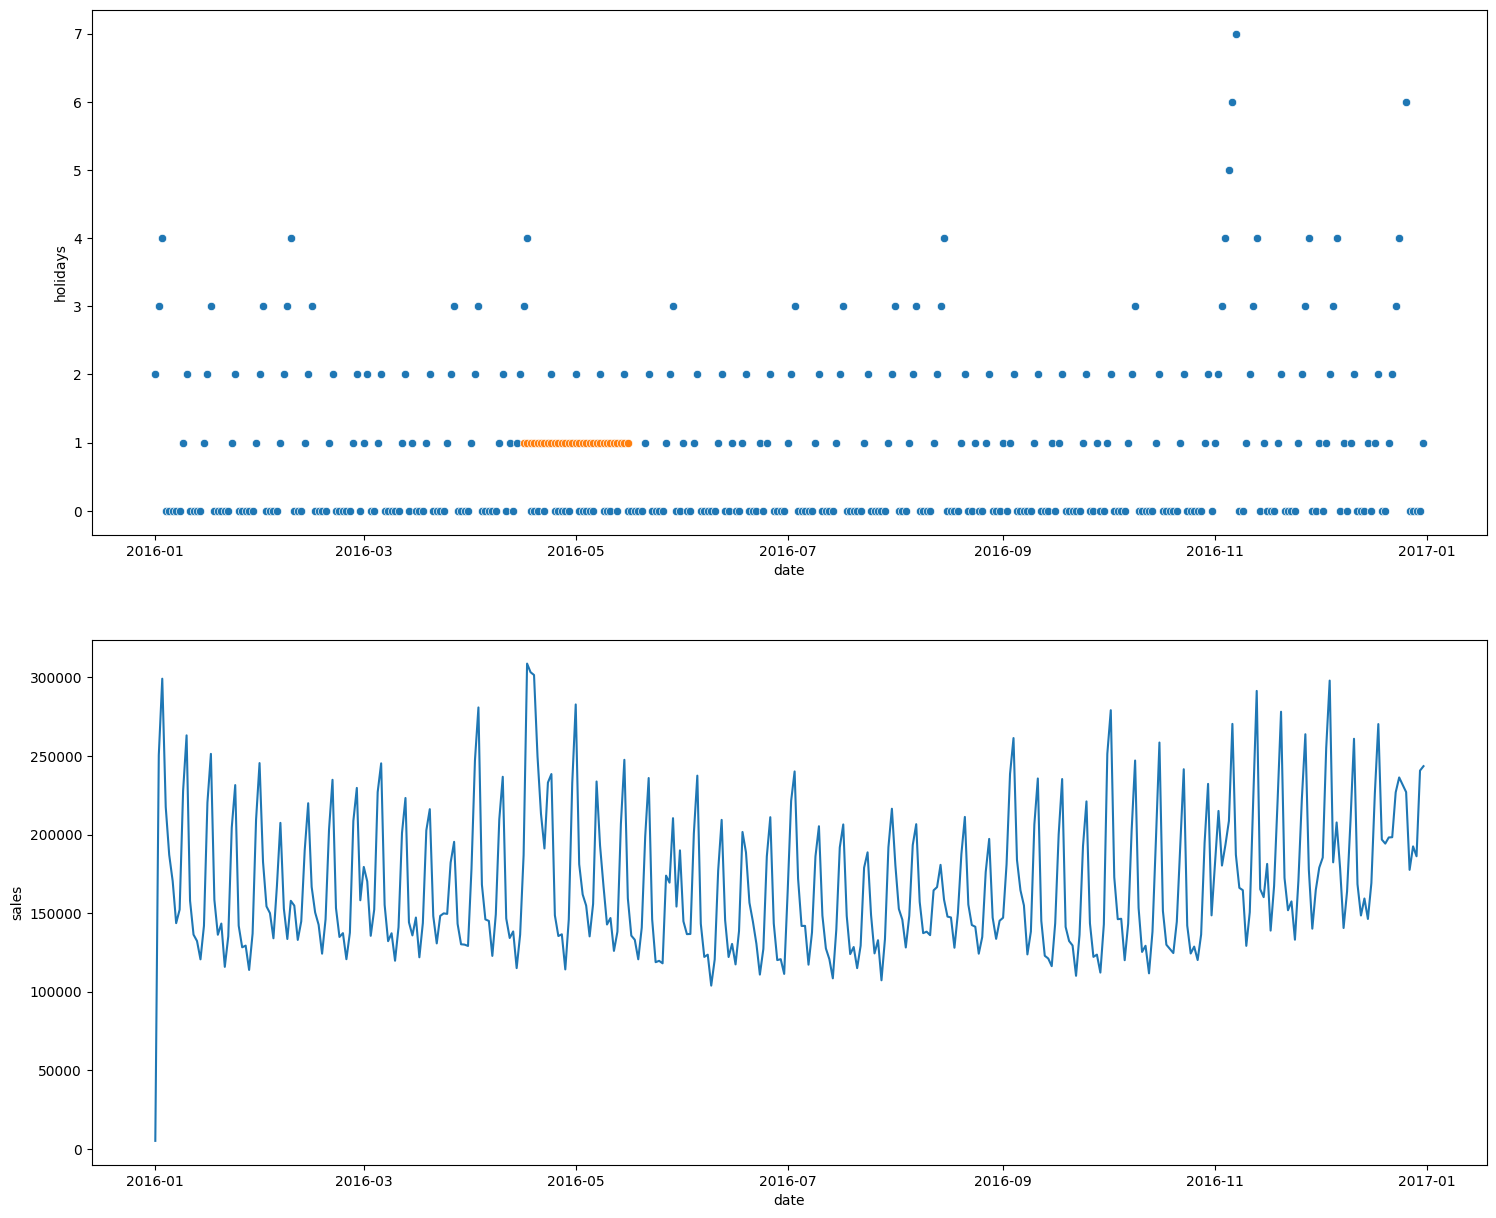

In [7]:
g = train.query('year == 2016')
# g = g.query('month >= 4')
g = g.query('family == "BEVERAGES"')
g = g.groupby('date').agg({
    'holidays': 'max'
    , 'earthquake': 'max'
    , target:'sum'
})

fig, ax = plt.subplots(2, figsize=(18,15))
sns.scatterplot(g['holidays'], ax=ax[0])
sns.scatterplot(g['earthquake'], ax=ax[0])
sns.lineplot(g[target], ax=ax[1])

# > Beating the Average
If I just used the average, what would it look like? The model that I will build must be better than the average. What the hell is the point if I cannot be better than the average.

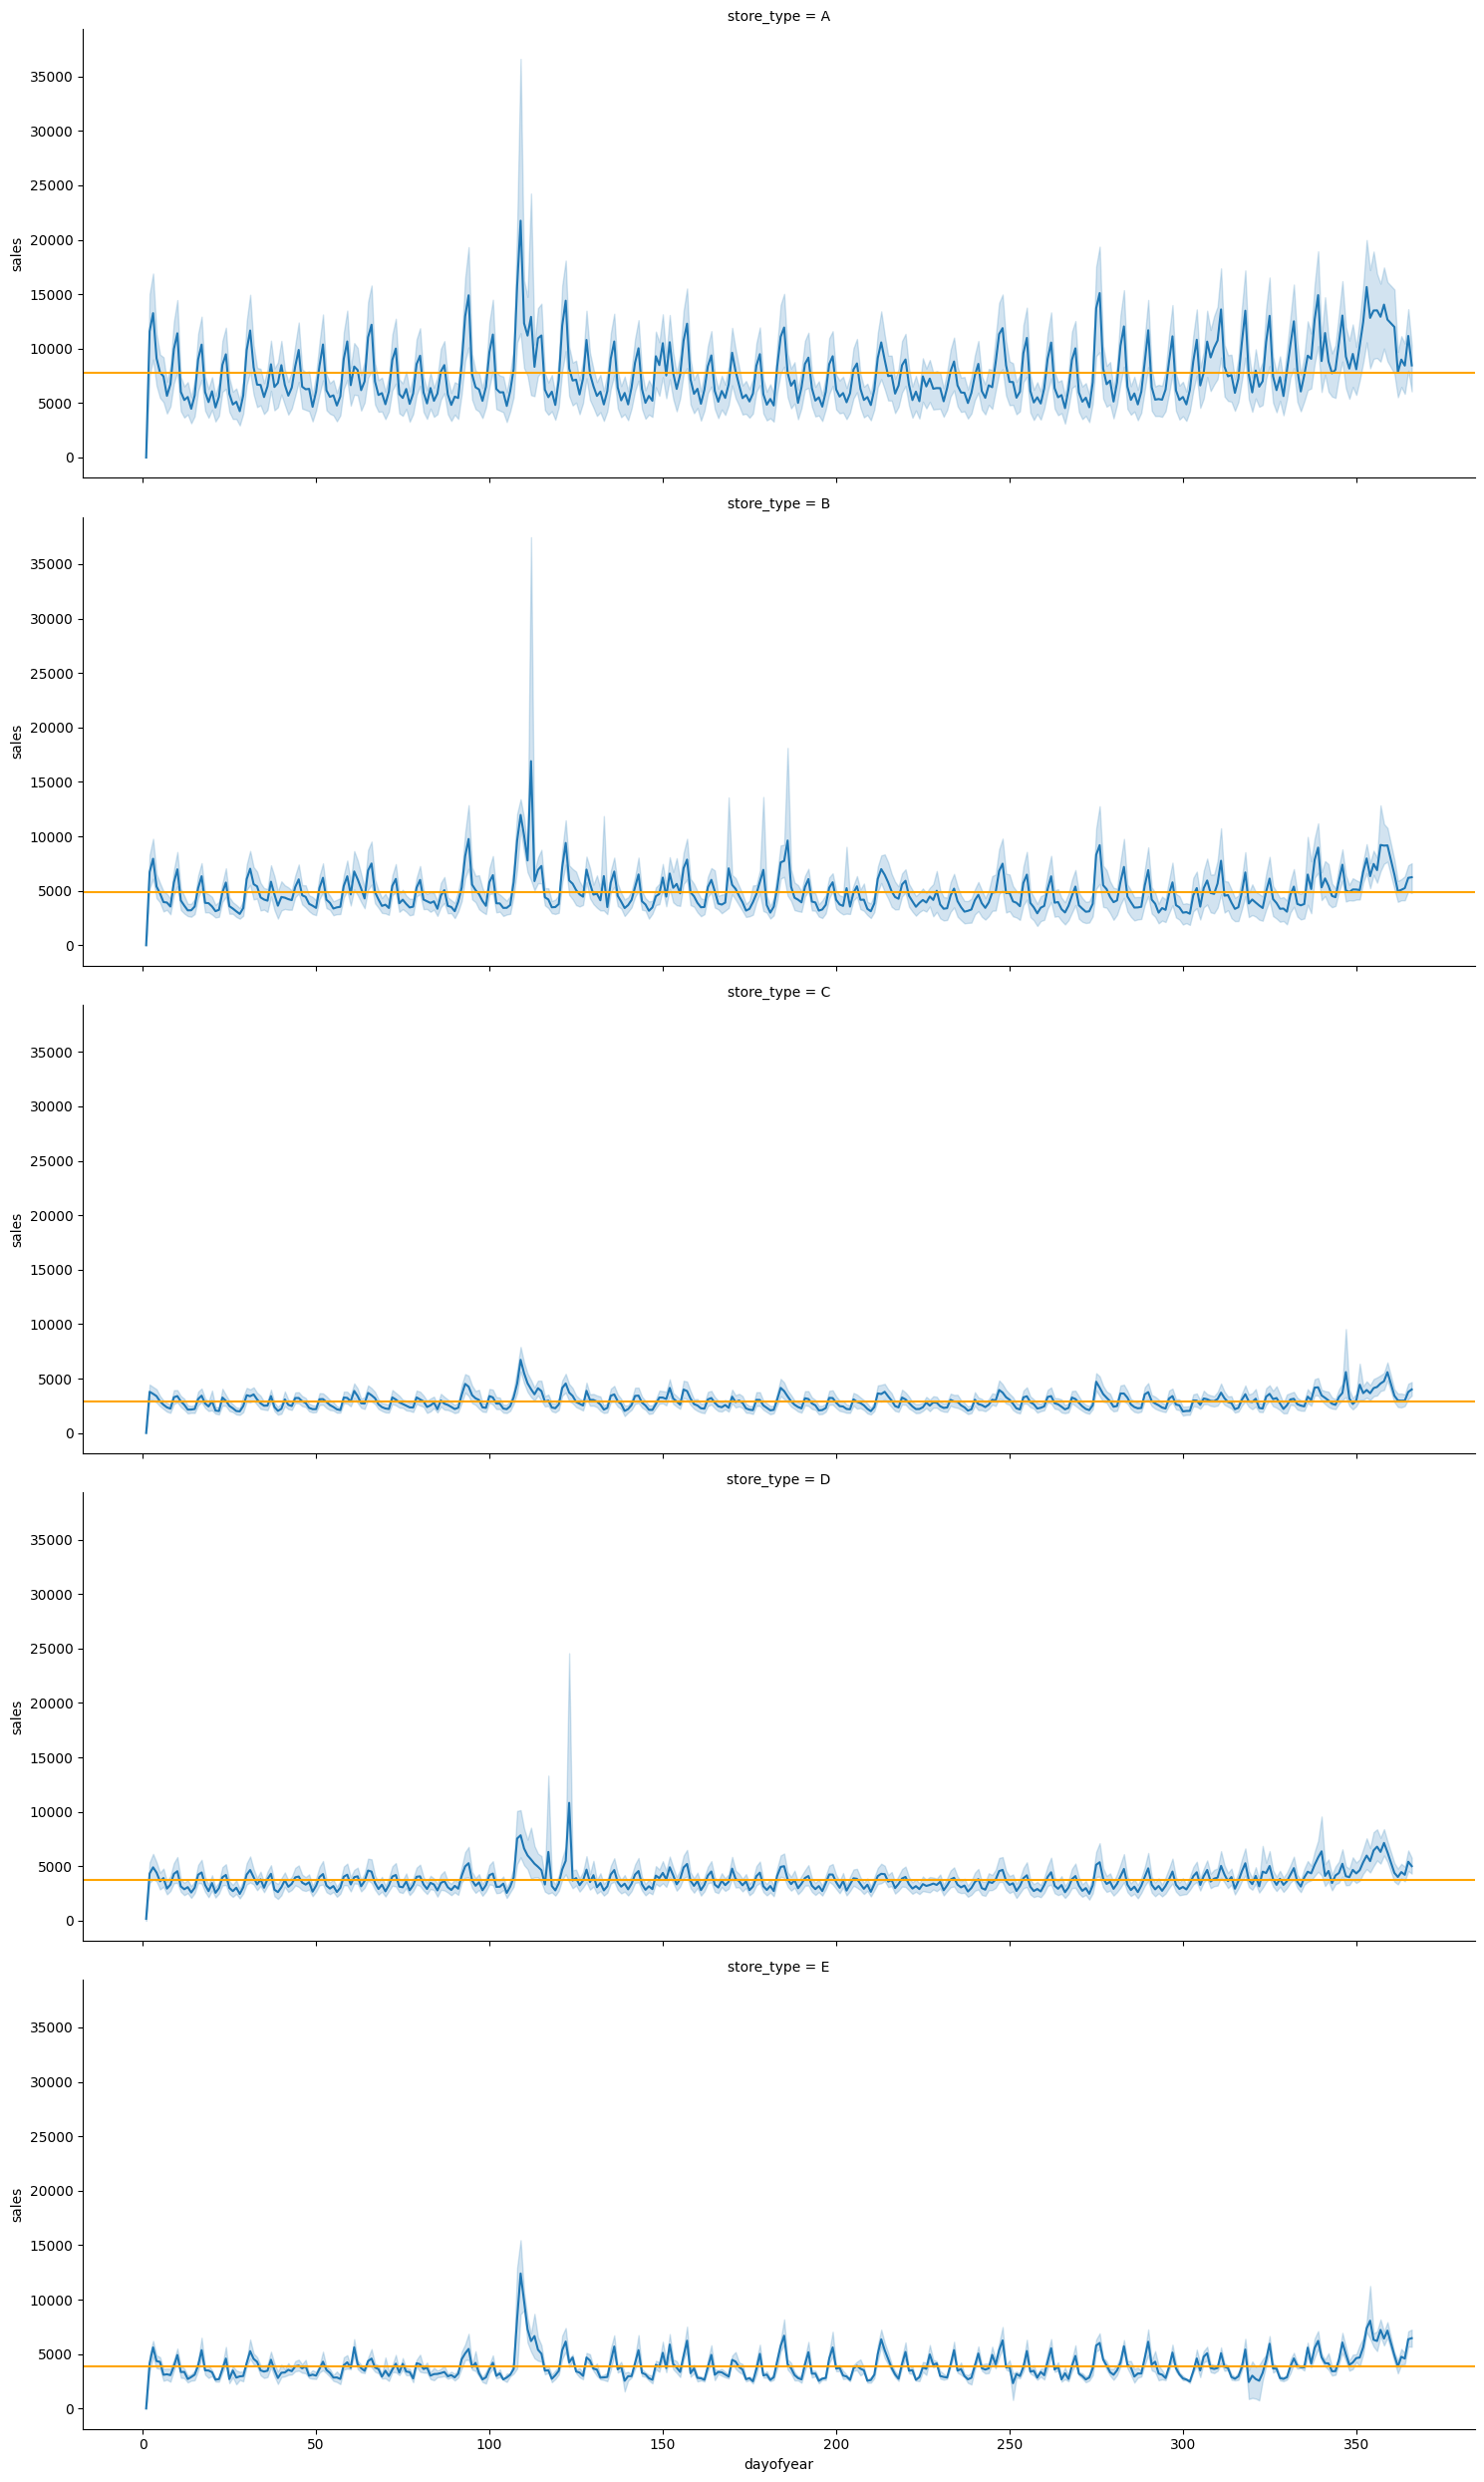

CPU times: user 58.2 s, sys: 466 ms, total: 58.7 s
Wall time: 58.1 s


In [8]:
%%time
d = train.query("family== 'GROCERY I'") ## Focus on GROCERY I
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type') ## Use groupby as an function object
m = g[target].mean() ## Easier to get means

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE') ## Graph timeseries by store_type
                , kind='line', aspect=3)

## Since I have relplot as an FacetGrid, I can get the axes
## individually and map mean as an axhline for each
## store_type.
for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

## The goal is to be comfortable at looking for a category
## that fits the target. And see if it is worth adding
## into the model.

# > Items with largest volume and volatility
Type A stores have more data. Will focus on this. Now, I need to see which products have the largest volume and deviations. The products that have low volume and does not have big swings, I will just use the average or zeros.

In [9]:
%%time
g = train.query('store_type=="A"')
g = g.groupby('family')[target].agg(['sum', 'std'])
g.sort_values(['sum'], ascending=False )

CPU times: user 81.4 ms, sys: 2.02 ms, total: 83.5 ms
Wall time: 80.6 ms


,sum,std
family,,
GROCERY I,2.541185e+07,4614.029682
BEVERAGES,1.959914e+07,3701.627743
PRODUCE,1.629640e+07,3472.685527
CLEANING,6.150316e+06,995.962813
DAIRY,5.790025e+06,1004.935188
BREAD/BAKERY,3.186882e+06,531.385370
POULTRY,3.053684e+06,614.165220
MEATS,2.612022e+06,451.811734
PERSONAL CARE,1.810113e+06,359.060609


# 🤖Model

# > Pipes

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, att, store_type, oil_price, holidays, earthquake, sales_band):
        self.att = att
        self.store_type = store_type
        self.oil_price = oil_price
        self.holidays = holidays
        self.earthquake = earthquake
        self.sales_band = sales_band
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = cleanData(X, self.store_type, self.oil_price, self.holidays, self.earthquake, self.sales_band) ## Find this at Top.
        return X[self.att]
    
num_pp = Pipeline([
    ('dataselect', DataSelect(
        ['onpromotion', 'weeknum', 'oil_price', 'holidays']
        , store_type, oil_price, holidays, earthquake, sales_band)
    )
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(
        ['weekname', 'month', 'earthquake', 'sales_band']
        , store_type, oil_price, holidays, earthquake, sales_band)
    )
    , ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

pipe = FeatureUnion([
    ('numeric', num_pp)
    , ('cat', cat_pp)
])

In [11]:
%%time
pipe.fit(train);
# train_pp = pipe.transform(train)
# test_pp = pipe.transform(test)

CPU times: user 12.3 s, sys: 273 ms, total: 12.6 s
Wall time: 12.5 s


# > Baseline

In [12]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def trainModels(d):
    ms = {}
    for member in d['family'].unique():
        for store in d['sales_band'].unique():
            trn = d.loc[(d['family'] == member) & (d['sales_band'] == store)]
            x_val = pipe.transform(trn)
            y_val = trn[target]
            model = RandomForestRegressor()
            model.fit(x_val, y_val)
            ms[member+'|'+store.astype(str)] = model
    return ms

def makePredictions(d, mod):
    pr = []
    for member in d['family'].unique():
        for store in d['sales_band'].unique():
            trn = d.loc[(d['family'] == member) & (d['sales_band'] == store)]
            x_val = pipe.transform(trn)
            pr.append(pd.Series(mod[member+'|'+store.astype(str)].predict(x_val), index=trn.index))
    return pd.concat(pr)

In [13]:
def getScores(d, m, p):
    return np.sqrt(
        - cross_val_score(
            m[d['family'].iloc[0]+'|'+d['sales_band'].iloc[0].astype(str)]
            , p.transform(d)
            , d[target]
            , scoring='neg_mean_squared_error'
        ).mean()
    )

In [14]:
%%time
models = trainModels(train)

CPU times: user 3min 20s, sys: 1.91 s, total: 3min 22s
Wall time: 3min 22s


# > Residuals. Make orange closer to blue dots.

In [15]:
g = train.groupby(['family', 'sales_band']).apply(getScores, models, pipe)#.sort_values(ascending=False)
g.xs(1, level='sales_band').sort_values(ascending=False)

family
GROCERY I                     1181.748236
BEVERAGES                      820.575678
PRODUCE                        621.744869
CLEANING                       349.426309
MEATS                          305.825739
DAIRY                          236.670054
BREAD/BAKERY                   170.046068
FROZEN FOODS                   123.724996
PERSONAL CARE                  110.665834
EGGS                            98.618465
LIQUOR,WINE,BEER                93.028043
DELI                            92.208831
HOME CARE                       88.402891
POULTRY                         71.284318
PREPARED FOODS                  28.411400
HOME AND KITCHEN I              15.838797
GROCERY II                       9.017159
HOME AND KITCHEN II              8.890495
CELEBRATION                      6.148184
LADIESWEAR                       6.042008
LAWN AND GARDEN                  5.561859
SEAFOOD                          4.710745
PLAYERS AND ELECTRONICS          3.978669
AUTOMOTIVE                 

In [16]:
g = train.groupby(['family', 'sales_band']).apply(getScores, models, pipe)#.sort_values(ascending=False)
g.xs(1, level='sales_band').sort_values(ascending=False)

family
GROCERY I                     1180.597591
BEVERAGES                      814.047446
PRODUCE                        629.705314
MEATS                          359.095665
CLEANING                       348.767713
DAIRY                          237.264996
BREAD/BAKERY                   171.218451
FROZEN FOODS                   123.758529
PERSONAL CARE                  109.586964
EGGS                            98.149029
LIQUOR,WINE,BEER                92.722391
DELI                            92.162030
HOME CARE                       88.590523
POULTRY                         71.186639
PREPARED FOODS                  28.458200
HOME AND KITCHEN I              15.799955
GROCERY II                       8.989923
HOME AND KITCHEN II              8.870326
CELEBRATION                      6.164990
LADIESWEAR                       6.027029
LAWN AND GARDEN                  5.568330
SEAFOOD                          4.688568
PLAYERS AND ELECTRONICS          3.985397
AUTOMOTIVE                 

In [17]:
g = test.groupby(['family', 'sales_band']).apply(getScores, models, pipe)#.sort_values(ascending=False)
g.xs(1, level='sales_band').sort_values(ascending=False)

family
GROCERY I                     1496.530562
BEVERAGES                     1249.691932
PRODUCE                       1077.060002
CLEANING                       736.027597
DAIRY                          324.694175
BREAD/BAKERY                   234.998085
PERSONAL CARE                  114.319002
DELI                           103.579624
HOME CARE                       98.792020
MEATS                           97.569164
POULTRY                         95.509118
EGGS                            95.352378
FROZEN FOODS                    70.675526
LIQUOR,WINE,BEER                64.887704
PREPARED FOODS                  44.342240
LAWN AND GARDEN                 22.378876
HOME AND KITCHEN I              18.990869
HOME AND KITCHEN II             15.878917
GROCERY II                      13.674282
SCHOOL AND OFFICE SUPPLIES      10.460074
CELEBRATION                      6.815268
SEAFOOD                          6.684114
LADIESWEAR                       6.665986
PLAYERS AND ELECTRONICS    

In [18]:
g = test.groupby(['family', 'sales_band']).apply(getScores, models, pipe)#.sort_values(ascending=False)
g.xs(1, level='sales_band').sort_values(ascending=False)

family
GROCERY I                     1481.978726
BEVERAGES                     1244.649678
PRODUCE                       1084.934248
CLEANING                       734.461258
DAIRY                          324.211414
BREAD/BAKERY                   232.127273
PERSONAL CARE                  115.506833
DELI                           103.780017
HOME CARE                       98.622053
MEATS                           97.275564
POULTRY                         96.151983
EGGS                            95.656426
FROZEN FOODS                    70.439957
LIQUOR,WINE,BEER                65.103980
PREPARED FOODS                  43.910004
LAWN AND GARDEN                 22.385745
HOME AND KITCHEN I              18.913915
HOME AND KITCHEN II             15.866968
GROCERY II                      13.650241
SCHOOL AND OFFICE SUPPLIES      10.457102
CELEBRATION                      6.829628
SEAFOOD                          6.725491
LADIESWEAR                       6.670251
PLAYERS AND ELECTRONICS    

CPU times: user 2.39 s, sys: 141 ms, total: 2.53 s
Wall time: 2.28 s


Text(0, 0.5, 'Predictions')

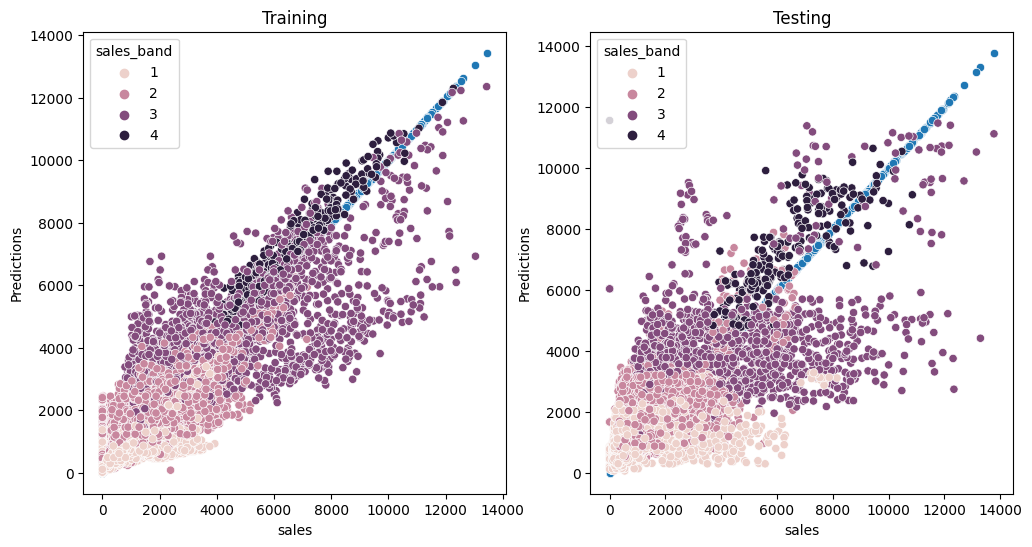

In [19]:
%%time
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
g = train.query('family == "PRODUCE"').copy()
g = g.query('year == 2016')
g = g.query('store_nbr not in (45,44,1,2,3,4,5,9,7,12,20)') ## f*cking outliers
g
sns.scatterplot(g, x=target, y=target, ax=ax[0]);
sns.scatterplot(g, x=target, y=makePredictions(g, models), ax=ax[0], hue='sales_band');
## improve this. you are in the right direction.
ax[0].set_title('Training')
ax[0].set_ylabel('Predictions')

g = test.query('family == "PRODUCE"').copy()
g = g.query('store_nbr not in (45,44,1,2,3,4,5,9,7,12,20)') ## f*cking outliers
g
sns.scatterplot(g, x=target, y=target, ax=ax[1]);
sns.scatterplot(g, x=target, y=makePredictions(g, models), ax=ax[1], hue='sales_band');
ax[1].set_title('Testing')
ax[1].set_ylabel('Predictions')

# sns.scatterplot(x=g[target],y=makePredictions(g, models), hue='year');
## improve this. you are in the right direction.

# > Predicted Demand vs Actual Sales
Why are the predictions lower than actual? I think it is because the predictions accounts for all types of stores. The lower volume stores are dragging the average down.

CPU times: user 15.5 s, sys: 253 ms, total: 15.8 s
Wall time: 15.4 s


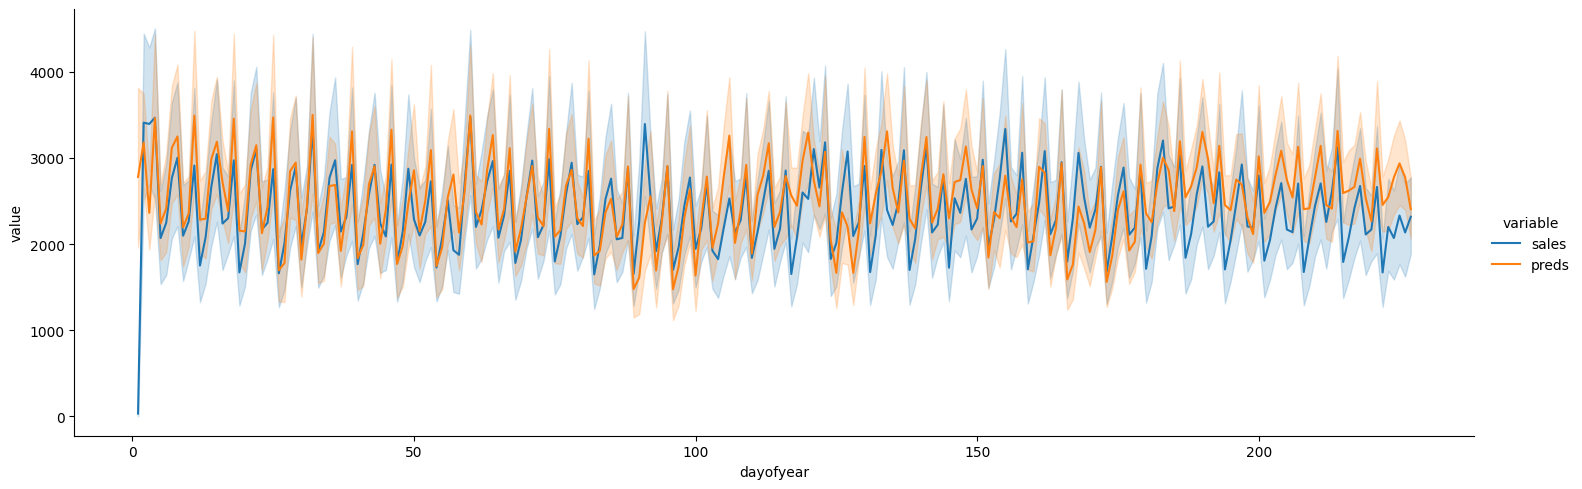

In [20]:
%%time
g = test.copy()
g = g.query('family == "PRODUCE"')
g['preds'] = makePredictions(g, models)

g = g[['store_nbr', 'sales', 'preds', 'dayofyear']]
g = pd.melt(g, id_vars=['store_nbr', 'dayofyear'])

sns.relplot(g, x='dayofyear', y='value', hue='variable'
            , kind='line', aspect=3);

CPU times: user 1min 33s, sys: 423 ms, total: 1min 34s
Wall time: 1min 33s


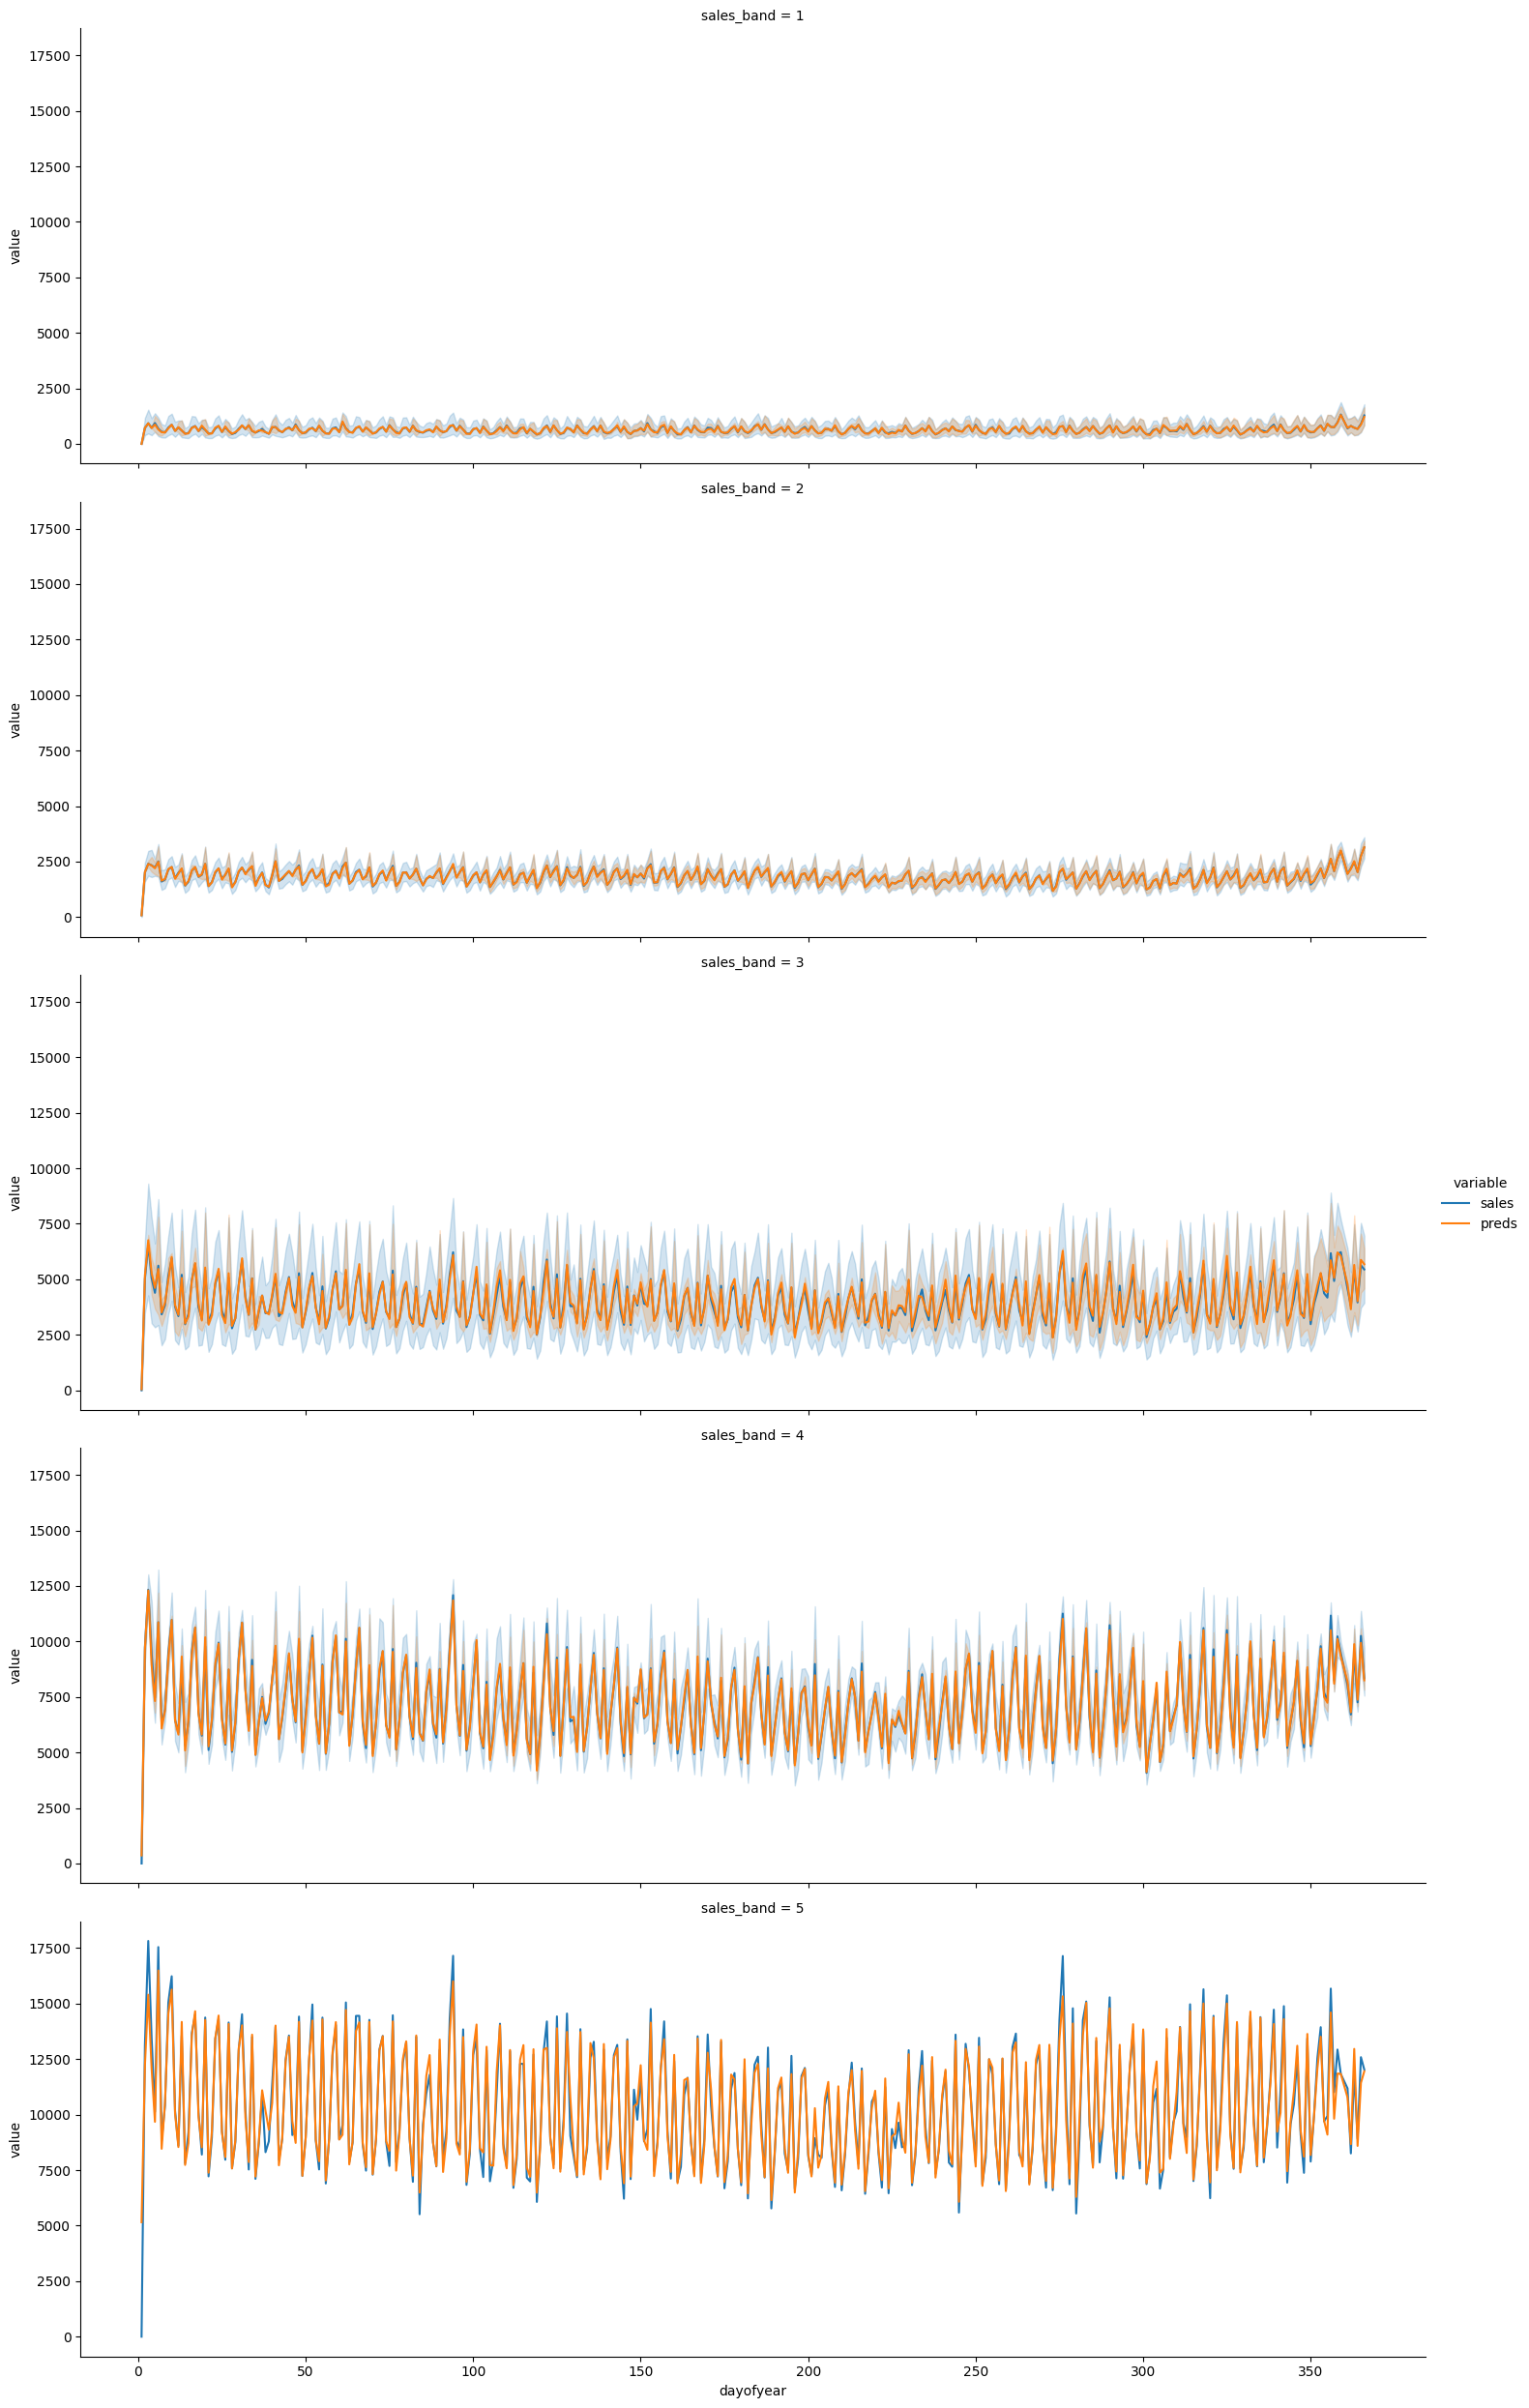

In [21]:
%%time
g = train.copy()
g = g.query('family == "PRODUCE"')
g['preds'] = makePredictions(g, models)

g = g[['sales_band', 'sales', 'preds', 'dayofyear']]
g = pd.melt(g, id_vars=['sales_band', 'dayofyear'])

sns.relplot(g, x='dayofyear', y='value', hue='variable'
            , row='sales_band'
            , kind='line', aspect=3);

# > Submission

In [22]:
samp = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
samp = cleanData(samp, store_type, oil_price, holidays, earthquake, sales_band)

pd.DataFrame({
    'id': samp['id']
    , 'sales': makePredictions(samp, models)
}).to_csv('submission.csv', index=False)

In [23]:
# %%time
# train['preds'] = makePredictions(train, models)
# train['dataset'] = 'train'
# test['preds'] = makePredictions(test, models)
# test['dataset'] = 'test'

# samp['preds'] = makePredictions(samp, models)
# samp['dataset'] = 'sample'
# export = pd.concat([train, test, samp], axis=0)
# # # %load_ext autoreload
# # # %autoreload 2
# import datawarehouse as dw
# dw.uploadData(export, "storesales_v09")